# Multiple RDPG

In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import networkx as nx
import seaborn as sns
import scipy.stats as stats
np.random.seed(8888)
from scipy.spatial.distance import cdist
import lap
from numpy import linalg as LA
from multiprocessing import cpu_count

from sklearn.metrics.pairwise import pairwise_kernels

import graspologic
from graspologic.inference import latent_distribution_test
from graspologic.embed import AdjacencySpectralEmbed, OmnibusEmbed
from graspologic.simulations import sbm, rdpg
from graspologic.utils import symmetrize
from graspologic.plot import heatmap, pairplot

import igraph as ig
from igraph import *

from scipy.sparse import csr_array
import random
%matplotlib inline

import psutil
import os
import time

In [9]:
!pip show numpy

Name: numpy
Version: 1.23.5
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /Users/tongqi/miniforge3/lib/python3.9/site-packages
Requires: 
Required-by: autograd, contourpy, gae, gcn, gensim, graspologic, graspy, gudhi, h5py, hyppo, imbalanced-learn, Keras-Preprocessing, lightgbm, matplotlib, mizani, numba, opt-einsum, pandas, patsy, persim, plotnine, POT, pyam-iamc, scikit-learn, scipy, seaborn, statsmodels, tensorboard, tensorflow, torchvision, umap-learn, wquantiles, xgboost


In [2]:
import platform
print(platform.python_version())
pid = os.getpid()
process = psutil.Process(pid)

3.9.15


In [5]:
def aseoos(Xhat, avec):
    n = Xhat.shape[0]
    
    if len(avec) != n:
        raise ValueError("Length of edge vector avec does not match size of latent position matrix Xhat.")
    
    # solve Xhat @ ooshat = avec
    # (really we're solving the linear least squares)
    ooshat = np.linalg.lstsq(Xhat.T @ Xhat, Xhat.T @ avec, rcond=None)[0]
    
    return ooshat

def array_split(data, m):
    rowIdx = np.arange(data.shape[0])
    # Split row indices into m groups
    split_indices = np.array_split(rowIdx, m)
    
    # Use the split indices to split the data array
    split_data = [data[x, :] for x in split_indices]
    
    return split_data

def check_repeated_rows(df):
    # Use duplicated() method to check for repeated rows
    duplicated_rows = df[df.duplicated()]
    if not duplicated_rows.empty:
        print("There are repeated rows.")
        print(duplicated_rows)
        print('numer is',duplicated_rows.shape )
    else:
        print("No repeated rows.")

def find_smallest_columns(row, num=1):# edit the k for softmatching
    return np.array(row.nsmallest(num).index)

def soft_matching_estimate(dists, oosB,vertex_shuffled,dim=10):
    dists_df = pd.DataFrame(dists)
    #ranked_df = dists_df.rank(axis=1, method='min')  # Using 'min' method for ranking
    dists_df.columns = [vertex_shuffled] #vertex_shuffled2
    dists_df.index = [vertex_shuffled]  
    #sorted_df = pd.DataFrame(np.sort(dists, axis=1), index=dists_df.index, columns=dists_df.columns)
    #check_repeated_rows(dists_df)
    smallest_columns = dists_df.apply(find_smallest_columns, axis=1)
    flattened_5cols = []
    for row in smallest_columns:
        flattened_5cols.append([item[0] for item in row])
    oosB_df = pd.DataFrame(oosB)
    oosB_df.index = [vertex_shuffled] 
    oosB_avg = np.zeros((len(vertex_shuffled), dim))
    for i in range(len(vertex_shuffled)):
        avg = np.array(oosB_df.loc[flattened_5cols[i]].mean())
        oosB_avg[i,:] = avg

    return oosB_avg

def pairwise_distances(embeddings):
    n = len(embeddings)
    distances = np.zeros((n, n))
    for i in range(n):
        for j in range(i+1, n):
            norm = LA.norm(embeddings[i] - embeddings[j], ord='fro') ** 2
            distances[i, j] = norm
            distances[j, i] = norm 
    return distances

In [125]:
n = 500
n_shuffle = int(n*0.2)
err = 0.05

kshuff = np.array([400]) # np.array([120])
j=0

dim = 10 
m = 10 # number of graphs
nMC = 200 


In [126]:
distance_matrix = []
distance_matrix2 = []
for h in range(nMC):
    m_graph_adjs = []
    m_graph_Xs = []
    m_graph_adjs = []
    m_graph_Xs = []
    m_unshuffled = []
    for i in range(m):
        X = np.random.dirichlet((1,1,1,1,1,1,1,1,1,1,1,1),n)
        X = np.delete(X, [10,11], 1)
        adj1 = rdpg(X)
        adj1.astype(int)
        m_graph_Xs.append(X)
        # m_graph_adjs.append(adj1)

    # get the same shuffled vertices
    order_original = np.arange(0, n)
    vertex_shuffled = np.random.choice(order_original, kshuff, replace=False)
    unshuf = [item for item in order_original if item not in vertex_shuffled]

    m_graph_Xs_shuffled = []
    for ori_X in m_graph_Xs:
        np.random.shuffle(vertex_shuffled)
        reorder_vertex = np.concatenate((unshuf, vertex_shuffled))
        X2 = ori_X[reorder_vertex,:]
        m_graph_Xs_shuffled.append(X2)

    # choose a random graph to add err 
    random_graph = 6 #random.randint(0, 9)
    err_X = m_graph_Xs_shuffled[random_graph]
    n_nodes_err = 80
    chosen_nodes = np.random.choice(vertex_shuffled, n_nodes_err, replace=False)
    for index in chosen_nodes:
        if index < err_X.shape[0]: 
            err_X[index] += err

    m_graph_adjs_shuffled = []
    m_graph_Xs_shuffled[random_graph] = err_X
    for X2 in m_graph_Xs_shuffled:
        adj2 = rdpg(X2)
        adj2.astype(int)
        m_graph_adjs_shuffled.append(adj2)
        MB = adj2[0:(500-int(kshuff)), :][:, 0:(500-int(kshuff))]
        m_unshuffled.append(MB)

    omni_embedder = OmnibusEmbed(n_components = dim)
    Zhats_m = omni_embedder.fit_transform(m_unshuffled)

    # choose last graph as anchor
    anchor_graph = m_graph_adjs_shuffled[m-1]
    oosA = np.zeros((kshuff[j], dim))
    for i in range(kshuff[j]):
        shuffle_vector = anchor_graph[500-kshuff[j]+i, :(500-kshuff[j])]
        point_est = aseoos(Zhats_m[m-1], shuffle_vector)
        oosA[i, :] = point_est
    newA_xs = np.vstack((Zhats_m[m-1], oosA))
    
    embeddings=[]
    for p in range(m-1):
        graph_adj = m_graph_adjs_shuffled[p]
        oosB = np.zeros((kshuff[j], dim))
        for i in range(kshuff[j]):
            shuffle_vector = graph_adj[500-kshuff[j]+i, :(500-kshuff[j])]
            point_est = aseoos(Zhats_m[p], shuffle_vector)
            oosB[i, :] = point_est
        
        dists = cdist(oosA, oosB, 'euclidean')
        cost, x1, y1 = lap.lapjv(dists)
        oosB_2 = oosB[x1]
        newB_xs = np.vstack((Zhats_m[p], oosB_2))
        embeddings.append(newB_xs)
    embeddings.append(newA_xs)
    
    dist_matrix = pairwise_distances(embeddings)
    distance_matrix.append(dist_matrix)

    embeddings2 = []
    for p in range(m):
        graph_adj = m_graph_adjs_shuffled[p]
        oosB = np.zeros((kshuff[j], dim))
        for i in range(kshuff[j]):
            shuffle_vector = graph_adj[500-kshuff[j]+i, :(500-kshuff[j])]
            point_est = aseoos(Zhats_m[p], shuffle_vector)
            oosB[i, :] = point_est
        newB_xs = np.vstack((Zhats_m[p], oosB))
        embeddings2.append(newB_xs)

    cost_matrix = np.zeros((len(embeddings2), len(embeddings2)))
    for i in range(len(embeddings2)):
        for k in range(len(embeddings2)):
            if i == k:
                cost_matrix[i, k] = 0
            else:
                A_emb = embeddings2[i]
                B_emb = embeddings2[k]
                #dists = cdist(oosA, oosB, 'euclidean')
                dists = cdist(A_emb, B_emb, 'euclidean')
                cost, x1, y1 = lap.lapjv(dists)
                cost_matrix[i, k] = cost

    distance_matrix2.append(cost_matrix)
    

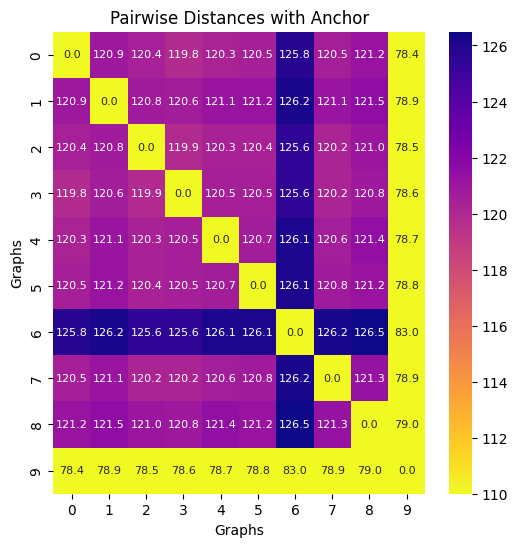

In [134]:
distance = np.mean(distance_matrix,axis=0)
unique_vals = np.unique(distance)
second_min = unique_vals[1]
plt.figure(figsize=(6, 6))
sns.heatmap(distance, annot=True, cmap='plasma_r', fmt=".1f", cbar=True,vmin=110, vmax=np.max(distance), annot_kws={"fontsize": 8})
plt.title("Pairwise Distances with Anchor")
plt.xlabel("Graphs")
plt.ylabel("Graphs")
plt.show()

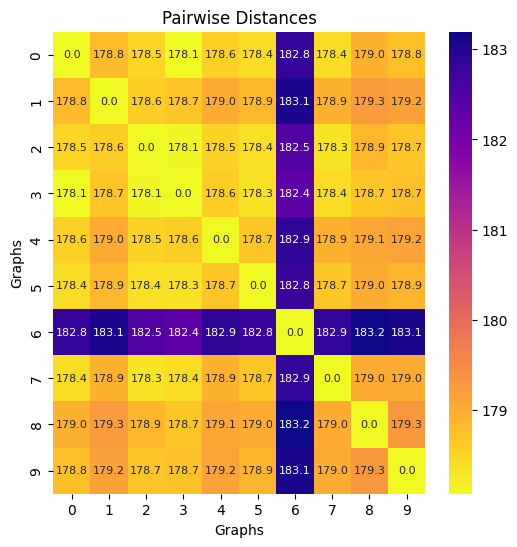

In [128]:
distance2 = np.mean(distance_matrix2,axis=0)
unique_vals = np.unique(distance2)
second_min = unique_vals[1]
plt.figure(figsize=(6, 6))
sns.heatmap(distance2, annot=True, cmap='plasma_r', fmt=".1f", cbar=True,vmin=second_min, vmax=np.max(distance2), annot_kws={"fontsize": 8})
plt.title("Pairwise Distances")
plt.xlabel("Graphs")
plt.ylabel("Graphs")
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
sns.heatmap(distance_matrix2, annot=True, cmap='plasma_r', fmt=".1f", cbar=True,vmin=30, vmax=50)
plt.title("Pairwise Distances")
plt.xlabel("Graphs")
plt.ylabel("Graphs")
plt.show()

In [10]:

distance_matrix = pairwise_distances(embeddings)
#print(distance_matrix)

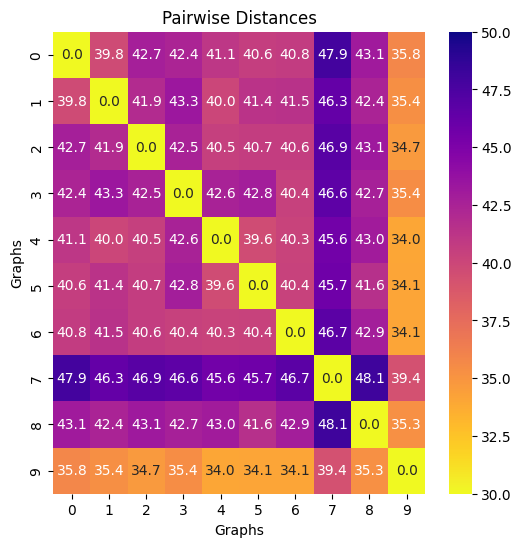

In [408]:
plt.figure(figsize=(6, 6))
sns.heatmap(distance_matrix, annot=True, cmap='plasma_r', fmt=".1f", cbar=True,vmin=30, vmax=50)
plt.title("Pairwise Distances")
plt.xlabel("Graphs")
plt.ylabel("Graphs")
plt.show()

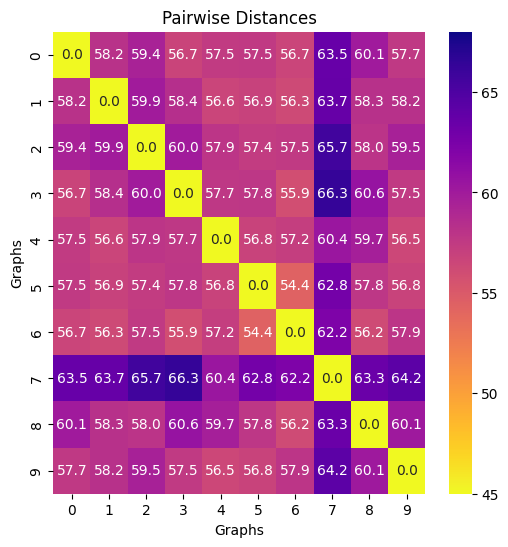

In [409]:
distance_matrix2 = pairwise_distances(embeddings2)
plt.figure(figsize=(6, 6))
sns.heatmap(distance_matrix2, annot=True, cmap='plasma_r', fmt=".1f", cbar=True,vmin=45, vmax=68)
plt.title("Pairwise Distances")
plt.xlabel("Graphs")
plt.ylabel("Graphs")
plt.show()

## Match 

In [4]:
def generate_dirichlet_data(n, num_components=12):
    X = np.random.dirichlet([1] * num_components, n) 
    X = np.delete(X, [-2, -1], axis=1)  
    return X

def add_names_to_matrix(matrix, row_names):
    # Convert numpy array to DataFrame with specified row and column names
    df = pd.DataFrame(matrix, index=row_names)
    return df

def find_smallest_columns(row, num=1):# edit the k for softmatching
    return np.array(row.nsmallest(num).index)

def soft_matching_estimate(dists, oosB,vertex_shuffled,dim=10):
    dists_df = pd.DataFrame(dists)
    #ranked_df = dists_df.rank(axis=1, method='min')  # Using 'min' method for ranking
    dists_df.columns = [vertex_shuffled] #vertex_shuffled2
    dists_df.index = [vertex_shuffled]  
    #sorted_df = pd.DataFrame(np.sort(dists, axis=1), index=dists_df.index, columns=dists_df.columns)
    #check_repeated_rows(dists_df)
    smallest_columns = dists_df.apply(find_smallest_columns, axis=1)
    flattened_5cols = []
    for row in smallest_columns:
        flattened_5cols.append([item[0] for item in row])
    oosB_df = pd.DataFrame(oosB)
    oosB_df.index = [vertex_shuffled] 
    oosB_avg = np.zeros((len(vertex_shuffled), dim))
    for i in range(len(vertex_shuffled)):
        avg = np.array(oosB_df.loc[flattened_5cols[i]].mean())
        oosB_avg[i,:] = avg

    return oosB_avg

from scipy.stats import spearmanr,kendalltau

def permutation_distance(vec1, vec2):
    return sum(v1 == v2 for v1, v2 in zip(vec1, vec2))

from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

In [11]:
n = 500 # 10000
kshuff = np.array([120,150]) #np.array([600,1500,3000]) # np.array([120]) # number shuffled in null
dims = [4,6]#[4,6,8,10,12,14] # embedding dim
m = 2 # number of graphs in test
nMC = 4 # 200
num = 1  # k for soft match

# spearmans = np.zeros((nMC, len(kshuff)))
# kendalls = np.zeros((nMC, len(kshuff)))
stats = {}
#alt_reg_a = np.zeros((nMC, len(lshuff)))
#alt_reg_a_avg = np.zeros((nMC, len(lshuff)))


In [12]:
for dim in dims:
    spearmans = np.zeros((nMC, len(kshuff)))
    softmatch_acc = np.zeros((nMC, len(kshuff)))
    for h in range(nMC):
        for j in range(len(kshuff)):
            X= generate_dirichlet_data(n=n, num_components=dim+2)
            adj1 = rdpg(X)
            adj1.astype(int)

            order_original = np.arange(0, n)
            ######
            vertex_shuffled = np.random.choice(order_original, kshuff[j], replace=False)
            ###### get the last k nodes and reverse their order 
            # vertex_shuffled = order_original[-kshuff[j]:]
            # vertex_shuffled = vertex_shuffled[::-1]

            #######
            #vertex_shuffled = np.arange(0,kshuff[j])

            np.random.shuffle(vertex_shuffled)

            unshuf = [item for item in order_original if item not in vertex_shuffled]
            reorder_vertex = np.concatenate((unshuf, vertex_shuffled))

            X2 = X[reorder_vertex,:]
            adj2 = rdpg(X2)
            adj2.astype(int)

            MA =  adj1[unshuf, :][:, unshuf]
            #MB =  adj2[unshuf, :][:, unshuf]
            MB = adj2[0:(n-kshuff[j]), :][:, 0:(n-kshuff[j])]

            omni_embedder = OmnibusEmbed(n_components = dim)
            Zhats12 = omni_embedder.fit_transform([MA, MB])
            MA_xhat = Zhats12[0]
            MB_xhat = Zhats12[1]

            # MA_xhat = add_names_to_matrix(MA_xhat,unshuf)
            # MB_xhat = add_names_to_matrix(MB_xhat,unshuf)

            # add this part 
            remaining_indices = np.setdiff1d(order_original, unshuf)
            MA_remain = adj1[remaining_indices,:][ :,unshuf]  #adj1[remaining_indices, :(n-kshuff[j])]
            MB_remain = adj2[-kshuff[j]:, :(n-kshuff[j])]
            

            oosA = np.zeros((kshuff[j], dim))
            for i in range(kshuff[j]):
                #shuffle_vector = adj1[n-kshuff[j]+i, :(n-kshuff[j])] # and this part
                shuffle_vector = MA_remain[i,:]
                point_est = aseoos(MA_xhat, shuffle_vector)
                oosA[i, :] = point_est

            oosB = np.zeros((kshuff[j], dim))
            for i in range(kshuff[j]):
                #shuffle_vector = adj2[n-kshuff[j]+i, :(n-kshuff[j])]
                shuffle_vector = MB_remain[i,:]
                point_est = aseoos(MB_xhat, shuffle_vector)
                oosB[i, :] = point_est

            dists = cdist(oosA, oosB, 'euclidean')
            cost, x1, y1 = lap.lapjv(dists)
            oosB_2 = oosB[x1]

            oosB_avg = soft_matching_estimate(dists,oosB,vertex_shuffled, dim = dim)


            #newA_xs = np.vstack((MA_xhat, oosA))  #pd.concat
            #newB_xs = np.vstack((MB_xhat, oosB_2)) #pd.concat

            A_nodes = np.append(unshuf, remaining_indices)
            B_nodes = np.append(unshuf, vertex_shuffled[x1])

            # spearman_corr, _ = spearmanr(A_nodes, B_nodes)
            # #print(f"Spearman Rank Correlation: {spearman_corr}")
            # spearmans[h,j] = spearman_corr

            # kendall_tau_corr, _ = kendalltau(A_nodes, B_nodes)
            # #print(f"Kendall's Tau Correlation: {kendall_tau_corr}")
            # kendalls[h,j] = kendall_tau_corr

            correct_matches = np.sum(remaining_indices == np.take(vertex_shuffled, x1))
            spearmans[h,j] = correct_matches/kshuff[j]

            # distance = permutation_distance(remaining_indices, vertex_shuffled[x1])
            # permutation_d[h,j] = distance

            # Soft matching accuracy (bc averages, so need to find closest vertex) (when the true match is in the top k guesses in oosB_avg)
            # soft_dists = cdist(oosA, oosB_avg, 'euclidean')  
            # num_best_guesses = np.argsort(soft_dists, axis=1)[:, :num]
            # matches = np.array([vertex_shuffled[i] in num_best_guesses[i] for i in range(len(kshuff))]) # find how many in oosB_avg were matched to one of the k best
            softmatch_acc[h, j] = 0 #np.mean(matches)
         
    stats[dim] = {
        "spearman_corr": spearmans,
        "softmatch": softmatch_acc}


In [56]:
j = 1
vertex_shuffled = np.arange(0,kshuff[j])
np.random.shuffle(vertex_shuffled)

In [6]:
# print(np.random.shuffle(np.arange(0,kshuff[j])))
# print(np.arange(0,kshuff[j]))

In [13]:
# spearman_value_60 = []
# spearman_value_120 = []
# spearman_value_300 = []
# spearman_var_60 = []
# spearman_var_120 = []
# spearman_var_300 = []
spearman_values = {k: [] for k in kshuff}
spearman_vars = {k: [] for k in kshuff}
softm_means = {k: [] for k in kshuff}
softm_vars = {k: [] for k in kshuff}
for key, matrices in stats.items():
    print(key)
    spearman_mean = np.mean(matrices['spearman_corr'], axis=0)
    spearman_var = np.var(matrices['spearman_corr'], axis=0)
    softm_mean = np.mean(matrices['softmatch'], axis=0)
    softm_var = np.var(matrices['softmatch'], axis=0)
    print(f"Spearman_mean: {spearman_mean}")
    print(f"spearman_var: {spearman_var}")
    print(f"softm_mean: {softm_mean}")
    print(f"softm_var: {softm_var}")
    for i, k in enumerate(kshuff):
        spearman_values[k].append(spearman_mean[i])
        spearman_vars[k].append(spearman_var[i])
        softm_means[k].append(softm_mean[i])
        softm_vars[k].append(softm_var[i])

    # spearman_value_60.append(spearman_mean[0])
    # spearman_value_120.append(spearman_mean[1])
    # spearman_value_300.append(spearman_mean[2])
    
    # spearman_var_60.append(spearman_var[0])
    # spearman_var_120.append(spearman_var[1])
    # spearman_var_300.append(spearman_var[2])
    

4
Spearman Rank Correlation: [0.1        0.07166667]
spearman_var: [0.0009375  0.00040833]
softm_mean: [0. 0.]
softm_var: [0. 0.]
6
Spearman Rank Correlation: [0.03958333 0.01833333]
spearman_var: [1.86631944e-04 5.27777778e-05]
softm_mean: [0. 0.]
softm_var: [0. 0.]


In [136]:
# data = {
#     'spearman_value_60': spearman_value_60,
#     'spearman_value_120': spearman_value_120,
#     'spearman_value_300': spearman_value_300,
#     'spearman_var_60': spearman_var_60,
#     'spearman_var_120': spearman_var_120,
#     'spearman_var_300': spearman_var_300,
# }
data = {
    f'spearman_value_{k}': spearman_values[k] for k in kshuff
} | {
    f'spearman_var_{k}': spearman_vars[k] for k in kshuff
} | {
    f'softm_means{k}': softm_means[k] for k in kshuff
} | {
    f'softm_vars{k}': softm_vars[k] for k in kshuff
} 
df = pd.DataFrame(data,index=dims)


NameError: name 'spearman_values' is not defined

In [22]:
df

,spearman_value_120,spearman_value_150,spearman_var_120,spearman_var_150,softm_means120,softm_means150,softm_vars120,softm_vars150
4,0.091667,0.05,0.000069,0.000011,0.0,0.0,0.0,0.0
6,0.029167,0.02,0.000017,0.000044,0.0,0.0,0.0,0.0


In [50]:
matrices['spearman_corr'].T[0].shape

(100,)

In [59]:
print(df['spearman_var_600'])
print(np.std(matrices['spearman_corr'].T[0], ddof=1/np.sqrt(200)

4     0.000801
6     0.000725
8     0.000897
10    0.000689
12    0.000502
14    0.000440
Name: spearman_var_600, dtype: float64
0.020994053172621492


In [135]:
plt.figure(figsize=(6, 5))

for k in kshuff:
    eb = plt.errorbar(
        df.index,
        df[f'spearman_value_{k}'],
        yerr=np.sqrt(df[f'spearman_var_{k}']),
        label=fr'Matching Accuracy $n_s = {k}$',
        marker='o',
        markersize=3,
        elinewidth=1,
        capsize=2,
        errorevery=1
    )
    eb[-1][0].set_linestyle('--')

plt.xlabel('Dimensions')
plt.ylabel('Matching Accuracy')
plt.title(f'Graph Matching on $n = {int(n / 1000)}k$ with Shuffled Nodes')
plt.xticks(df.index)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.1)
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'df' is not defined

<Figure size 600x500 with 0 Axes>

In [15]:
def print_mem():
    print(f"Memory used: {process.memory_info().rss / (1024 ** 2):.2f} MB")

# Example usage
print_mem()
data = [i for i in range(10**7)]
print_mem()

Memory used: 721.06 MB
Memory used: 1032.03 MB


In [16]:
plt.figure(figsize=(6, 5))
eb1 = plt.errorbar(df.index, df[f'spearman_value_{k}'], 
             yerr=np.sqrt(df['spearman_var_600']), 
             label=fr'Matching Accuracy $n_s = {kshuff[0]}$',
             marker='o',markersize=3,
             elinewidth=1,capsize=2,errorevery=1)
eb1[-1][0].set_linestyle('--')

eb2 = plt.errorbar(df.index, df['spearman_value_1500'], 
             yerr=np.sqrt(df['spearman_var_1500']), 
             label=fr'Matching Accuracy $n_s = {kshuff[1]}$', 
             marker='o',markersize=3,
             elinewidth=1,capsize=2,errorevery=1 )
eb2[-1][0].set_linestyle('--')
eb3 = plt.errorbar(df.index, df['spearman_value_3000'], 
             yerr=np.sqrt(df['spearman_var_3000']), 
             label=fr'Matching Accuracy $n_s = {kshuff[2]}$', 
             marker='o',markersize=3,
             elinewidth=1,capsize=2,errorevery=1 )
eb3[-1][0].set_linestyle('--')
plt.xlabel('Dimensions')
plt.ylabel('Matching Accuracy')
plt.title(f'Graph Matching on $n = {int(n/1000)}k$ with Shuffled Nodes')
plt.xticks(df.index)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.1)
plt.legend()

plt.show()

KeyError: 'spearman_value_600'

<Figure size 600x500 with 0 Axes>

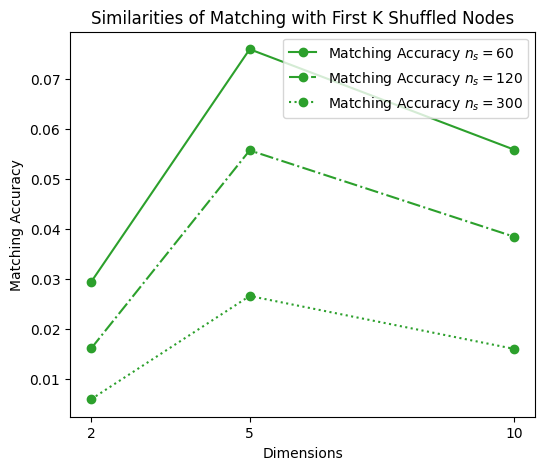

In [8]:
data = {
    'spearman_value_60': spearman_value_60,
    'spearman_value_120': spearman_value_120,
    'spearman_value_300': spearman_value_300,
    'permutation_60': permutation_60,
    'permutation_120': permutation_120
}
df = pd.DataFrame(data,index=dims)
plt.figure(figsize=(6, 5))

plt.plot(df.index, df['spearman_value_60'], label=r'Matching Accuracy $n_s = 60$ ', marker='o', color = '#2ca02c')
plt.plot(df.index, df['spearman_value_120'], label=r'Matching Accuracy $n_s = 120$', marker='o',color = '#2ca02c',linestyle = '-.')
plt.plot(df.index, df['spearman_value_300'], label=r'Matching Accuracy $n_s = 300$', marker='o',color = '#2ca02c',linestyle = ':')
#plt.plot(df.index, df['permutation_60'], label=r'Permutation Distance $n_s = 60$', marker='v',color = '#ff7f0e')
#plt.plot(df.index, df['permutation_120'], label=r'Permutation Distance $n_s = 120$', marker='v',color = '#ff7f0e',linestyle = '-.')

plt.xlabel('Dimensions')
plt.ylabel('Matching Accuracy')
plt.title('Similarities of Matching with First K Shuffled Nodes')
plt.xticks(df.index)

plt.legend()

plt.show()

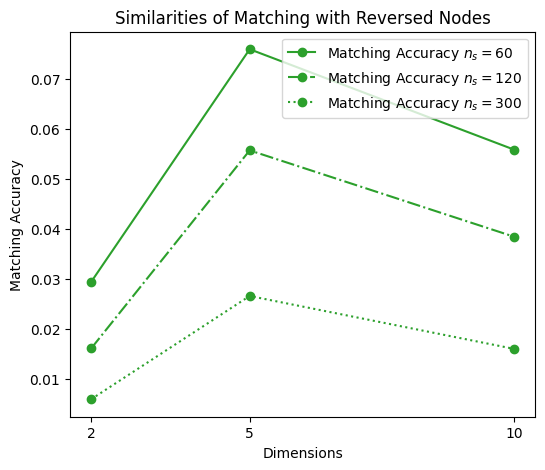

In [9]:
data = {
    'spearman_value_60': spearman_value_60,
    'spearman_value_120': spearman_value_120,
    'spearman_value_300': spearman_value_300,
    'permutation_60': permutation_60,
    'permutation_120': permutation_120
}
df = pd.DataFrame(data,index=dims)
plt.figure(figsize=(6, 5))

plt.plot(df.index, df['spearman_value_60'], label=r'Matching Accuracy $n_s = 60$ ', marker='o', color = '#2ca02c')
plt.plot(df.index, df['spearman_value_120'], label=r'Matching Accuracy $n_s = 120$', marker='o',color = '#2ca02c',linestyle = '-.')
plt.plot(df.index, df['spearman_value_300'], label=r'Matching Accuracy $n_s = 300$ ', marker='o', color = '#2ca02c',linestyle =':' )
#plt.plot(df.index, df['permutation_60'], label=r'Permutation Distance $n_s = 60$', marker='v',color = '#ff7f0e')
#plt.plot(df.index, df['permutation_120'], label=r'Permutation Distance $n_s = 120$', marker='v',color = '#ff7f0e',linestyle = '-.')

plt.xlabel('Dimensions')
plt.ylabel('Matching Accuracy')
plt.title('Similarities of Matching with Reversed Nodes')
plt.xticks(df.index)

plt.legend()

plt.show()

In [83]:

def aseoos2(Xhat, avec):
    n = Xhat.shape[0]
    
    if avec.shape[0] != n:
        raise ValueError('Length of edge vector avec does not match size of latent position matrix Xhat.')
    
    ooshat = np.linalg.lstsq(Xhat, avec, rcond=None)[0]
    ooshat = ooshat.T 
    
    return ooshat

from mvlearn.embed import omnibus


ModuleNotFoundError: No module named 'mvlearn'

In [85]:
# !pip3 install mvlearn

In [70]:
### test 
n = 20
dims = [2]#[2,10,20,30]
j=1
kshuff[j] = 10
oosAs = []
oosB_2s = []

for dim in dims:
    X= generate_dirichlet_data(n=n, num_components=dim+2)
    adj1 = rdpg(X)
    adj1.astype(int)

    order_original = np.arange(0, n)
      ######
    vertex_shuffled = np.random.choice(order_original, kshuff[j], replace=False)
    ###### get the last k nodes and reverse their order 
    # vertex_shuffled = order_original[-kshuff[j]:]
    # vertex_shuffled = vertex_shuffled[::-1]

    #######
    #vertex_shuffled = np.arange(0,kshuff[j])
    unshuf = [item for item in order_original if item not in vertex_shuffled]
    reorder_vertex = np.concatenate((unshuf, vertex_shuffled))

    X2 = X[reorder_vertex,:]
    # X2 = X
    adj2 = rdpg(X2)
    adj2.astype(int)

    MA =  adj1[unshuf, :][:, unshuf]
    #MB =  adj2[unshuf, :][:, unshuf]
    MB = adj2[0:(n-kshuff[j]), :][:, 0:(n-kshuff[j])]

    omni_embedder = OmnibusEmbed(n_components = dim)
    Zhats12 = omni_embedder.fit_transform([MA, MB])
    MA_xhat = Zhats12[0]
    MB_xhat = Zhats12[1]

    MA_xhat = add_names_to_matrix(MA_xhat,unshuf)
    MB_xhat = add_names_to_matrix(MB_xhat,unshuf)

    # add this part 
    remaining_indices = np.setdiff1d(order_original, unshuf) # this is the true positions 
    MA_remain = adj1[remaining_indices, :(n-kshuff[j])]
    MB_remain = adj2[-kshuff[j]:, :(n-kshuff[j])]

    oosA = np.zeros((kshuff[j], dim))
    for i in range(kshuff[j]):
        #shuffle_vector = adj1[500-kshuff[j]+i, :(500-kshuff[j])] # and this part
        shuffle_vector = MA_remain[i,:]
        point_est = aseoos(MA_xhat, shuffle_vector)
        oosA[i, :] = point_est

    oosB = np.zeros((kshuff[j], dim))
    for i in range(kshuff[j]):
        #shuffle_vector1 = adj2[n-kshuff[j]+i, :(n-kshuff[j])]
        shuffle_vector2 = MB_remain[i,:]
        #print(shuffle_vector1)
        #print(shuffle_vector2)
        point_est1 = aseoos(MB_xhat, shuffle_vector2)
        #point_est2 = aseoos2(MB_xhat, shuffle_vector2)
        #print(point_est1)
        #print(point_est2)
        oosB[i, :] = point_est1

    oosA_test = add_names_to_matrix(oosA,remaining_indices)
    oosB_test = add_names_to_matrix(oosB,vertex_shuffled)

    dists = cdist(oosA, oosB, 'euclidean')
    cost, x1, y1 = lap.lapjv(dists)
    #oosB_2 = oosB.iloc[x1]
    oosB_2 = oosB[x1]


    oosAs.append(oosA)
    oosB_2s.append(oosB_2)


In [79]:
adj1[unshuf,:]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
        0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0.]])

In [72]:
vertex_shuffled

array([11, 18,  0, 19, 10, 17, 15,  1,  3,  7])

In [75]:
MA

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

<function matplotlib.pyplot.show(close=None, block=None)>

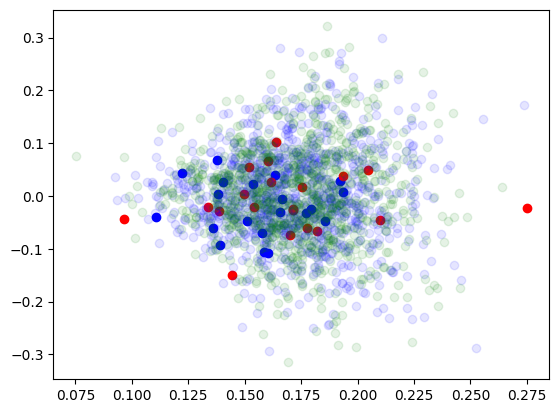

In [67]:
plt.scatter(oosAs[3][:,0],oosAs[3][:,1],color = 'blue')
plt.scatter(oosB_2s[3][:,0],oosB_2s[3][:,1],color = 'red')
# plt.scatter(oosB[:,0],oosB[:,1],color = 'yellow')
# plt.scatter(oosB_3[:,0],oosB_3[:,1],color = 'purple')
# plt.scatter(test1[:,0],test1[:,1],color = 'green')
# plt.scatter(X[:,0],X[:,1],color = 'red', marker = '<',alpha = 0.1)
# plt.scatter(X2[:,0],X2[:,1],color = 'yellow', marker = '<',alpha = 0.1)
plt.scatter(MA_xhat[0],MA_xhat[1],color = 'blue',alpha = 0.1)
plt.scatter(MB_xhat[0],MB_xhat[1],color = 'green',alpha = 0.1)
plt.show

In [68]:
n = 20
order_original = np.arange(0, n)
######
vertex_shuffled = np.random.choice(order_original, 10, replace=False)
###### get the last k nodes and reverse their order 
# vertex_shuffled = order_original[-kshuff[j]:]
# vertex_shuffled = vertex_shuffled[::-1]

#######
#vertex_shuffled = np.arange(0,kshuff[j])
unshuf = [item for item in order_original if item not in vertex_shuffled]
reorder_vertex = np.concatenate((unshuf, vertex_shuffled))

In [69]:
print(vertex_shuffled)
print(unshuf)

[18  8  6  5  1 10  9  7 11 12]
[0, 2, 3, 4, 13, 14, 15, 16, 17, 19]


In [55]:
print(dists.shape)

(10, 10)


In [9]:
# test 
print(remaining_indices)
print(vertex_shuffled)
order =  [np.where(vertex_shuffled == x)[0][0] for x in remaining_indices]
#print(order)
print(vertex_shuffled[order])
print(remaining_indices[x1])
test = permutation_distance(remaining_indices, vertex_shuffled[x1])
print(test)
test2 = permutation_distance(remaining_indices, vertex_shuffled)
print(test2)

[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7 8 9]
[7 3 5 9 6 0 2 4 8 1]
9
0


In [88]:
print(remaining_indices[y1])
print(remaining_indices[x1])

[0 8 2 4 3 6 9 1 5 7]
[0 7 2 4 3 8 5 9 1 6]


In [12]:
# force to get correct order 
test1 = oosB[order]
test1_d = LA.norm(test1 - oosA, ord='fro') ** 2
print(test1_d)
# dist of shuffled to original
test2_d = LA.norm(oosB - oosA, ord='fro') ** 2
print(test2_d)
# dist of aligned to original
test3_d = LA.norm(oosB_2 - oosA, ord='fro') ** 2
print(test3_d)
test3_dd = LA.norm(oosB_3 - oosA, ord='fro') ** 2
print(test3_dd)
test4 = LA.norm(oosB_2 - test1, ord='fro') ** 2
print(test4)
test5 = LA.norm(oosB_2 - oosB, ord='fro') ** 2
print(test5)
test6 = LA.norm(test1 - oosB, ord='fro') ** 2
print(test6)
test7 = LA.norm(oosA_test - oosA, ord='fro') ** 2
print(test7)

0.6925650298409325
0.6925650298409325
0.1248087256322176
0.6495931908110533
0.6562578051496161
0.6562578051496161
0.0
0.0


array([[ 0.4208741 , -0.12633024, -0.20797574, -0.06136108],
       [ 0.22622253, -0.08012964, -0.15292554, -0.07965521],
       [ 0.37776026,  0.10725527,  0.2652499 , -0.09416312],
       [ 0.17430351, -0.15275098, -0.06379129, -0.00451711],
       [ 0.33994875,  0.13894053, -0.01348338,  0.20514096],
       [ 0.25774802, -0.13445837,  0.09391501, -0.16375229],
       [ 0.22557964, -0.08435836,  0.19769872, -0.01195977],
       [ 0.15368996,  0.04027261, -0.18601362, -0.11529042],
       [ 0.16489301, -0.15195992, -0.10187428, -0.14446501],
       [ 0.16274754, -0.06984447, -0.05778836, -0.16536123]])

In [12]:
## test
cost_matrix = np.array([[7,9,8,9,9],
                        [2,8,5,7,9],
                        [1,6,6,9,9],
                        [3,6,2,2,9],
                        [3,6,4,5,6]])

# Solve the LAP using lapjv
cost, row_ind, col_ind = lap.lapjv(cost_matrix)

# Print the results
print(f"Minimum cost: {cost}")
print(f"Row indices: {row_ind}")
print(f"Column indices: {col_ind}")

Minimum cost: 23.0
Row indices: [4 0 1 3 2]
Column indices: [1 2 4 3 0]


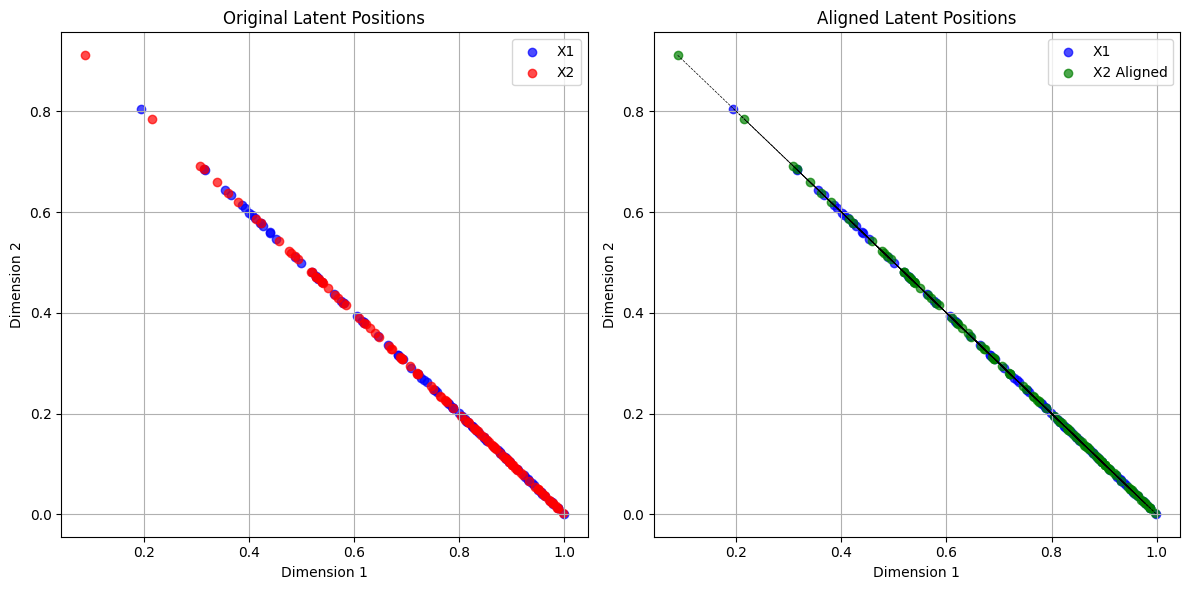

Total cost of assignment: 2.375541086890501


In [32]:
import numpy as np
import matplotlib.pyplot as plt
import lap

# Set parameters
n = 100  # number of samples
dim = 2  # dimension of latent positions

# Generate latent positions from a Dirichlet(1,1) distribution.
# This yields points on a 2D simplex.
X1 = np.random.dirichlet([3, 1], n)  # shape (n, 2)
X2 = np.random.dirichlet([3, 1], n)  # shape (n, 2)

# Compute the cost matrix (using Euclidean distance between each pair of latent positions)
cost_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        cost_matrix[i, j] = np.linalg.norm(X1[i] - X2[j])

# Solve the assignment problem using lap.lapjv.
# lap.lapjv returns a tuple (row_ind, col_ind, total_cost).
# For each row i, col_ind[i] gives the index in X2 that best matches X1[i].
total_cost, row_ind, col_ind  = lap.lapjv(cost_matrix)

# Use the assignment to reorder X2 so that it aligns with X1.
X2_aligned = X2[col_ind, :]

# Plot the original latent positions (X1 and X2) and then the aligned positions.
plt.figure(figsize=(12, 6))

# Plot the original positions.
plt.subplot(1, 2, 1)
plt.scatter(X1[:, 0], X1[:, 1], color='blue', label='X1', alpha=0.7)
plt.scatter(X2[:, 0], X2[:, 1], color='red', label='X2', alpha=0.7)
plt.title("Original Latent Positions")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)

# Plot the aligned positions.
plt.subplot(1, 2, 2)
plt.scatter(X1[:, 0], X1[:, 1], color='blue', label='X1', alpha=0.7)
plt.scatter(X2_aligned[:, 0], X2_aligned[:, 1], color='green', label='X2 Aligned', alpha=0.7)
# Draw dashed lines connecting matched pairs
for i in range(n):
    plt.plot([X1[i, 0], X2_aligned[i, 0]], [X1[i, 1], X2_aligned[i, 1]], 'k--', linewidth=0.5)
plt.title("Aligned Latent Positions")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Total cost of assignment:", total_cost)

In [28]:
row_ind

9.530876163929753

In [ ]:
# Soft matching accuracy (bc averages, so need to find closest vertex) (when the true match is in the top k guesses in oosB_avg)
soft_dists = cdist(oosA, oosB_avg, 'euclidean')  
num_best_guesses = np.argsort(soft_dists, axis=1)[:, :num]
matches = np.array([order_shuffled[i] in num_best_guesses[i] for i in range(len(kshuff))]) # find how many in oosB_avg were matched to one of the k best
prop_corr_soft[h, j] = np.mean(matches)

# TEST

In [176]:
# this is where k is changed
def find_smallest_columns(row, num):# edit the k for softmatching
    return np.array(row.nsmallest(num).index)

def soft_matching_estimate(dists, oosB, vertex_shuffled, dim, num):
    # avg latent positions for soft matching
    dists_df = pd.DataFrame(dists)
    #ranked_df = dists_df.rank(axis=1, method='min')  # Using 'min' method for ranking
    dists_df.columns = [vertex_shuffled] #vertex_shuffled2
    dists_df.index = [vertex_shuffled]  
    #sorted_df = pd.DataFrame(np.sort(dists, axis=1), index=dists_df.index, columns=dists_df.columns)
    #check_repeated_rows(dists_df)
    # smallest_columns = dists_df.apply(find_smallest_columns, axis=1)
    smallest_columns = dists_df.apply(lambda x: find_smallest_columns(x, num), axis=1)
    flattened_5cols = []
    for row in smallest_columns:
        flattened_5cols.append([item[0] for item in row])
    oosB_df = pd.DataFrame(oosB)
    oosB_df.index = [vertex_shuffled] 
    oosB_avg = np.zeros((len(vertex_shuffled), dim))
    for i in range(len(vertex_shuffled)):
        avg = np.array(oosB_df.loc[flattened_5cols[i]].mean())
        oosB_avg[i,:] = avg

    return oosB_avg

In [210]:
def prop_plot(n, dim, num, nMC=100):
    kshuff = int(n/500)*np.array([20,30,40,50,60,80,90,100,110,120]) # upscale shuffling with n

    # Finding the proportion of correctly recovered vertices after shuffling in omni-OOS and softmatch
    prop_corr = np.zeros((nMC, len(kshuff)))
    prop_corr_soft = np.zeros((nMC, len(kshuff)))
    for h in range(nMC):
        # print(h) # sanity check
        # np.save("mc_progress.npy", np.array([h]))
        # with open("mc_progress.txt", "w") as f:
            # f.write('prop_n'+str(n)+'_nMC'+str(nMC)+'_d'+str(dim)+'_k'+str(num)+'iter_'+str(h))
        # if h%20==0:
        #     print(h) # sparser sanity check
        for j in range(len(kshuff)):
            X = np.random.dirichlet(np.ones(dim + 2), n)  # Use dim + 2 to ensure deletion leaves dim(X) = dim
            X = np.delete(X, [dim, dim + 1], axis=1)  # Remove two dimensions to get final (n, dim)
            adj1 = rdpg(X)
            adj1.astype(int)

            order_original = np.arange(0, n)
            order_shuffled = list(reversed(np.arange(kshuff[j])))
            # vertex_shuffled = np.random.choice(order_original, kshuff[j], replace=False) # pick shuffled labels (random order, scrapped bc too hard to recover for softmatch)
            vertex_shuffled = list(reversed(np.arange(n-kshuff[j], n)))                  # pick shuffled labels (backwards order)
            true_positions = list(np.arange(n - kshuff[j], n))                           # true order of shuffled labels
            unshuf = [item for item in order_original if item not in vertex_shuffled]    # find corresp. unshuffled labels
            reorder_vertex = np.concatenate((unshuf, vertex_shuffled))                   # concatenate to get labels for unshuffled + shuffled as a matrix

            X2 = X[reorder_vertex,:]                                                     # new reordered X
            adj2 = rdpg(X2)                                                              # adjacency matrix for reordered X
            adj2.astype(int)

            MA =  adj1[unshuf, :][:, unshuf]                                             # adjacency for unshuffled part of unshuffled graph
            MB = adj2[0:(n-kshuff[j]), :][:, 0:(n-kshuff[j])]                            # adjacency for unshuffled part of shuffled graph

            omni_embedder = OmnibusEmbed(n_components = dim)                             # omnibus embedding of lower "dim" dimensions in embedded space
            Zhats12 = omni_embedder.fit_transform([MA, MB])                              # joint embedding of MA and MB into the same space
            MA_xhat = Zhats12[0]                                                         # omnibus low dim embedding of latent positions for MA (unshuffled part from original)
            MB_xhat = Zhats12[1]                                                         # omnibus low dim embedding of latent positions for MB (unshuffled part from shuffled)

            oosA = np.zeros((kshuff[j], dim)) # oos embedding for shuffled nodes in A (unshuffled)
            for i in range(kshuff[j]):
                shuffle_vector = adj1[n-kshuff[j]+i, :(n-kshuff[j])]
                point_est = aseoos(MA_xhat, shuffle_vector)                              # estimate of latent positions used to get projections of shuffled nodes
                oosA[i, :] = point_est

            oosB = np.zeros((kshuff[j], dim)) # oos embedding for shuffled nodes in B (shuffled)
            for i in range(kshuff[j]):
                shuffle_vector = adj2[n-kshuff[j]+i, :(n-kshuff[j])]                 # connections between shuffled and unshuffled in shuffled graph
                point_est = aseoos(MB_xhat, shuffle_vector)                              # estimate of latent positions used to get projections of shuffled nodes
                oosB[i, :] = point_est
            
            # Hard matching
            dists = cdist(oosA, oosB, 'euclidean')
            _, x1, _ = lap.lapjv(dists)  # LAP solver for optimal assignment
            oosB_2 = oosB[x1]  # Reordered embeddings

            # Soft matching
            # oosB_avg = soft_matching_estimate(dists, oosB, vertex_shuffled, dim, num)

            # Hard matching accuracy (could also compare x1 to (kshuff, kshuff-1,...,0))
            correct_matches = np.sum(true_positions == np.take(vertex_shuffled, x1)) # match true labels (of shuffled vertices) to shuffled labels after matching
            prop_corr[h, j] = correct_matches / kshuff[j]

            # Soft matching accuracy (bc averages, so need to find closest vertex) (when the true match is in the top k guesses in oosB_avg)
            # soft_dists = cdist(oosA, oosB_avg, 'euclidean')  
            num_best_guesses = np.argsort(dists, axis=1)[:, :num]
            # matches = np.array([order_shuffled[i] in num_best_guesses[i] for i in range(len(kshuff))]) # find how many in oosB_avg were matched to one of the k best
            undo_shuff = list(np.arange(kshuff[j])) # unshuffling order/matching order, i.e. (0,1,2,...,kshuff[j])
            matches = np.array([undo_shuff[i] in num_best_guesses[i] for i in np.arange(kshuff[j])]) # matching the indices (not labels) of original order and the indices of the kshuff[j] best guesses
            prop_corr_soft[h, j] = np.mean(matches)

    df = pd.DataFrame(np.vstack((kshuff, prop_corr)).T)
    df.columns = ["kshuff"] + list(np.arange(nMC))
    df['mean'] = df.iloc[:, 1:(nMC+1)].mean(axis=1)
    df['SE'] = np.sqrt(df['mean']*(1-df['mean'])/np.sqrt(nMC))

    df_soft = pd.DataFrame(np.vstack((kshuff, prop_corr_soft)).T)
    df_soft.columns = ["kshuff"] + list(np.arange(nMC))
    df_soft['mean'] = df_soft.iloc[:, 1:(nMC+1)].mean(axis=1)
    df_soft['SE'] = np.sqrt(df_soft['mean']*(1-df_soft['mean'])/np.sqrt(nMC))

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.errorbar(kshuff, df['mean'], yerr=df['SE'], fmt='o-', 
                capsize=5, label='Omni-OOS', markersize=5)

    plt.errorbar(kshuff, df_soft['mean'], yerr=df_soft['SE'], fmt='s-', 
                capsize=5, label=f'Omni-OOS soft matching ({num})', markersize=5)
    plt.xlabel("Number of Vertices Shuffled")
    plt.ylabel("Proportion Correctly Recovered")
    plt.title('Proportion recovered vertices after shuffling \n on RDPG, n =' + str(n) + 
            ', nMC='+str(nMC)+ ', d='+str(dim))  # + str(err)
    plt.legend()
    plt.grid(True)
    plt.show()

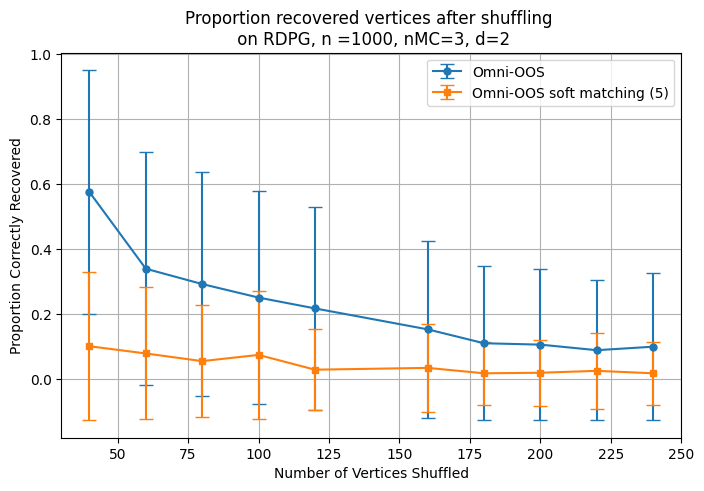

In [212]:
prop_plot(n=1000, dim=2, num=5,nMC=3)